# Decision Tree with Scikit-Learn

## Basic Decision Tree

Reference: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.08-Random-Forests.ipynb


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Consider the following two-dimensional data, which has one of four class labels:

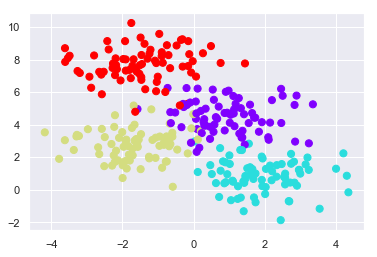

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. This figure presents a visualization of the first four levels of a decision tree classifier for this data:

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

A quick utility function to help us visualize the output of the classifier:

In [4]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Now we can examine what the decision tree classification looks like:

C:\Users\kulkarni\Miniconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


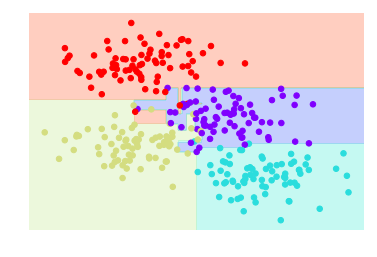

In [5]:
visualize_classifier(DecisionTreeClassifier(), X, y)

## Classification Trees
Example: Titanic survival data set: https://github.com/justmarkham/DAT5/blob/master/code/19_advanced_sklearn.py

### Building a Classification Tree in scikit-learn


In [6]:
%matplotlib inline
import pandas as pd

# Read in the data.
path = 'data/titanic.csv'
titanic = pd.read_csv(path)

# Encode female as 0 and male as 1.
titanic['Sex'] = titanic.Sex.map({'female':0, 'male':1})

# Fill in the missing values for age with the median age.
titanic.Age.fillna(titanic.Age.median(), inplace=True)

# Create a DataFrame of dummy variables for Embarked.
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

# Concatenate the original DataFrame and the dummy DataFrame.
titanic = pd.concat([titanic, embarked_dummies], axis=1)

# Print the updated DataFrame.
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,1


### Features
- Survived: 0=died, 1=survived (response variable)
- Pclass: 1=first class, 2=second class, 3=third class
- Sex: 0=female, 1=male
- Age: Numeric value
- Embarked: C or Q or S

Think: What will happen if the tree splits on these feature?

In [7]:
# Define X and y.
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']

X = titanic[feature_cols]
y = titanic.Survived

In [8]:
# Fit a classification tree with max_depth=3 on all data.
from sklearn.tree import DecisionTreeClassifier

treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [9]:
from sklearn.tree import export_graphviz

# Create a Graphviz file.
export_graphviz(treeclf, out_file='data/tree_titanic.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_titanic.dot -o tree_titanic.png

# Or, just drag this image to your desktop or Powerpoint.

In [10]:
# Compute the feature importances (the Gini index at each node).

pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,Pclass,0.242664
1,Sex,0.655584
2,Age,0.064494
3,Embarked_Q,0.000000
4,Embarked_S,0.037258


In [11]:
from sklearn.model_selection import cross_val_score
# try max_depth=2
treeclf = DecisionTreeClassifier(max_depth=2, random_state=1)
cross_val_score(treeclf, X, y, cv=10, scoring='roc_auc').mean()

0.8018358515123222

In [12]:
# try max_depth=3
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
cross_val_score(treeclf, X, y, cv=10, scoring='roc_auc').mean()

0.8427518744871685

In [13]:
# use GridSearchCV to automate the search
from sklearn.model_selection import learning_curve, GridSearchCV

treeclf = DecisionTreeClassifier(random_state=1)
depth_range = range(1, 32)
param_grid = dict(max_depth=depth_range)
grid = GridSearchCV(treeclf, param_grid, cv=10, scoring='roc_auc')
grid.fit(X, y)

# check the results of the grid search
grid.cv_results_
grid_mean_scores = [result[1] for result in grid.cv_results_]

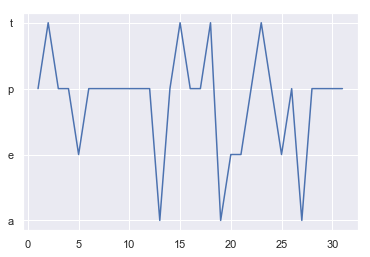

In [14]:
import matplotlib.pyplot as plt
plt.plot(depth_range, grid_mean_scores)

In [15]:
# what was best?
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8508455218067684
{'max_depth': 5}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


## Regression Trees
Reference : Decision Trees, Joseph Nelson (DC)

Dataset: https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_train.csv

In this section, we will make decision trees that predict numeric data. Instead of returning a class, we will return a single numeric value for each set of conditions.

Training data is a tiny data set of used vehicle sale prices. Your goal is to predict price for testing data.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# allow plots to appear in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

# Vehicle data
path = 'data/vehicles_train.csv'
train = pd.read_csv(path)

In [17]:
# Before splitting anything, just predict the mean of the entire data set.
train['prediction'] = train['price'].mean()
train

,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,6571.428571
1,14000,2010,30000,2,car,6571.428571
2,13000,2010,73500,4,car,6571.428571
3,9500,2009,78000,4,car,6571.428571
4,9000,2007,47000,4,car,6571.428571
5,4000,2006,124000,2,car,6571.428571
6,3000,2004,177000,4,car,6571.428571
7,2000,2004,209000,4,truck,6571.428571
8,3000,2003,138000,2,car,6571.428571
9,1900,2003,160000,4,car,6571.428571


In [18]:
# Calculate RMSE for those predictions.
from sklearn import metrics
import numpy as np

np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

5936.981985995983

In [19]:
# Define a function that calculates the RMSE for a given split of miles.
def mileage_split(miles):
    lower_mileage_price = train[train['miles'] < miles].price.mean()
    higher_mileage_price = train[train['miles'] >= miles].price.mean()
    train['prediction'] = np.where(train['miles'] < miles, lower_mileage_price, higher_mileage_price)
    return np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

In [20]:
# Calculate RMSE for tree that splits on miles < 50,000.
print('RMSE:', mileage_split(50000))
train

RMSE: 3984.0917425414564


,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,15000.000000
1,14000,2010,30000,2,car,15000.000000
2,13000,2010,73500,4,car,4272.727273
3,9500,2009,78000,4,car,4272.727273
4,9000,2007,47000,4,car,15000.000000
5,4000,2006,124000,2,car,4272.727273
6,3000,2004,177000,4,car,4272.727273
7,2000,2004,209000,4,truck,4272.727273
8,3000,2003,138000,2,car,4272.727273
9,1900,2003,160000,4,car,4272.727273


In [21]:

# Calculate RMSE for tree that splits on miles < 100,000.
print('RMSE:', mileage_split(100000))
train

RMSE: 3530.146530076269


,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,12083.333333
1,14000,2010,30000,2,car,12083.333333
2,13000,2010,73500,4,car,12083.333333
3,9500,2009,78000,4,car,12083.333333
4,9000,2007,47000,4,car,12083.333333
5,4000,2006,124000,2,car,2437.500000
6,3000,2004,177000,4,car,2437.500000
7,2000,2004,209000,4,truck,2437.500000
8,3000,2003,138000,2,car,2437.500000
9,1900,2003,160000,4,car,2437.500000


In [22]:
# Check all possible mileage splits.
mileage_range = list(range(train['miles'].min(), train['miles'].max(), 1000))
RMSE = [mileage_split(miles) for miles in mileage_range]

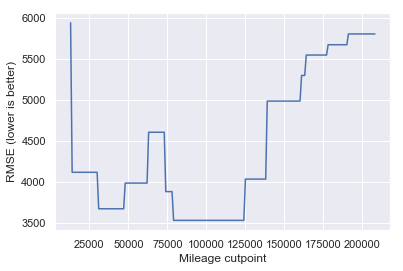

In [23]:
# Plot mileage cutpoint (x-axis) versus RMSE (y-axis).
plt.plot(mileage_range, RMSE);
plt.xlabel('Mileage cutpoint');
plt.ylabel('RMSE (lower is better)');

Recap: Before every split, we repeat this process for every feature and choose the feature and cutpoint that produce the lowest MSE.

### Building a Regression Tree in scikit-learn

In [24]:

# Encode car as 0 and truck as 1.
train['vtype'] = train['vtype'].map({'car':0, 'truck':1})

In [25]:

# Define X and y.
feature_cols = ['year', 'miles', 'doors', 'vtype']

X = train[feature_cols]
y = train['price']

In [26]:
# Instantiate a DecisionTreeRegressor (with random_state=1).
from sklearn.tree import DecisionTreeRegressor

treereg = DecisionTreeRegressor(random_state=1)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [27]:
# Use leave-one-out cross-validation (LOOCV) to estimate the RMSE for this model.
from sklearn.model_selection import cross_val_score
k_folds =  5
scores = cross_val_score(treereg, X, y, cv=5, scoring='neg_mean_squared_error',)
np.mean(np.sqrt(-scores))

3218.7405261206713

### Tuning a Regression Tree
Let's try to reduce the RMSE by tuning the max_depth parameter:

In [28]:
# Try different values one by one.
treereg = DecisionTreeRegressor(max_depth=1, random_state=1)
scores = cross_val_score(treereg, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

4384.997970037612


Or, we could write a loop to try a range of values:

In [29]:
# List of values to try:
max_depth_range = list(range(1, 8))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []


for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

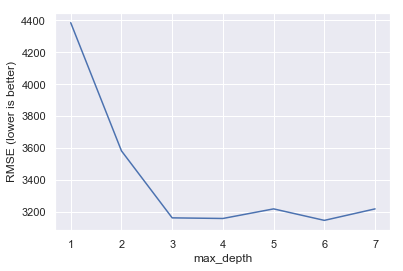

In [30]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

In [31]:
# max_depth=3 was best, so fit a tree using that parameter.
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [32]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature.
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,year,0.798744
1,miles,0.201256
2,doors,0.000000
3,vtype,0.000000


### Creating a Tree Diagram
To create a tree diagram, we will use the Graphviz library for displaying graph data structures.

Surprisingly, every tree is just a graph in disguise! A graph is a tree only if there is exactly one vertex with no incoming edge (the root), while all other vertices have exactly one incoming edge (representing its parent).

In [33]:
# Create a Graphviz file.
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='data/tree_vehicles.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_vehicles.dot -o tree_vehicles.png

# Or, you can drag the image below to your desktop or Powerpoint!

### Making Predictions for the Testing Data


In [34]:
# Read the testing data.
path = 'data/vehicles_test.csv'

test = pd.read_csv(path)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


Question: Using the tree diagram above, what predictions will the model make for each observation?


In [35]:
# Use fitted model to make predictions on testing data.
X_test = test[feature_cols]
y_test = test.price
y_pred = treereg.predict(X_test)

y_pred

array([ 4000.,  5000., 13500.])

In [36]:
# Calculate RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

1190.2380714238084

In [37]:
# Calculate RMSE for your own tree.
y_test = [3000, 6000, 12000]
y_pred = [0, 0, 0]

from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

7937.253933193771